# DSCI 100 Group 16 Project Proposal

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)
library(readxl)

set.seed(16)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Preliminary Exploratory Data Analysis

### Creating a usable data set

The data that we downloaded from the website was already in tidy format because each row represented an observation, each column is a single variable, and each value is a single cell. We removed all the 'NA' from the table and also removed all the discreet variables (Id, Education, Marital_Status, Complain) because we can't use them in the classification model since they are not continuous.
We made the data set a bit more usuable by:
- combining the Kidhome and Teenhome columns into a Childhome column
- combining the amount spent on all the different categories of food into a single Total_Spent column
- using the Year_Birth column to find the customer's age (this data was published at the end of 2022)
- changing the date the customer joined to the number of weeks they've been a customer
- changing the marital status column to single ()/not single ()
- changing response to a factor


In [2]:
data <- read_csv("superstore_data.csv")
date_2 = as.Date("2022-12-31")
store_data <- data |>
    na.omit() |>
    select(-Id, -Education, -Complain) |>
    mutate(Childhome = Kidhome + Teenhome) |>
    select(-Kidhome, -Teenhome) |>
    mutate(Age = 2022 - Year_Birth) |>
    select(-Year_Birth) |>
    mutate(Total_Spent = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts) |>
    select(-MntWines, -MntFruits, -MntMeatProducts, -MntFishProducts, -MntSweetProducts) |>
    mutate(Dt_Customer = as.Date(Dt_Customer, "%m/%d/%Y")) |>
    mutate(Weeks_Customer = difftime(date_2, Dt_Customer, units = "weeks")) |>
    mutate(Weeks_Customer = as.numeric(Weeks_Customer)) |>
    select(-Dt_Customer) |>
    mutate(Relationship = case_when(Marital_Status == 'Married' | Marital_Status == 'Together' ~ 'Yes',
                                    Marital_Status !=  'Married' & Marital_Status != 'Together' ~ 'No')) |>
    select(-Marital_Status) |>
    mutate(Response = as.factor(Response))
store_data

Rows: 2240 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Education, Marital_Status, Dt_Customer
dbl (19): Id, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Income,Recency,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Childhome,Age,Total_Spent,Weeks_Customer,Relationship
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
84835,0,218,1,4,4,6,1,1,0,52,972,445.7143,No
57091,0,37,1,7,3,7,5,1,0,61,540,445.8571,No
67267,0,30,1,3,2,5,2,0,1,64,221,450.5714,Yes
32474,0,0,1,1,0,2,7,0,2,55,11,425.4286,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
31056,99,16,1,1,0,3,8,0,1,45,39,518.5714,Yes
46310,99,14,2,6,1,5,8,0,1,46,295,563.7143,No
65819,99,63,1,5,4,10,3,0,0,44,1320,526.2857,Yes
94871,99,144,1,8,5,4,7,1,2,53,934,572.7143,Yes


### Exploring the data
We then split our data in 75% training and 25% testing data. We see that we have 14 variables, but we will not use all of them.
We would like to focus on the variables: Income, Childhome, Age, Total_Spent, and Weeks_Customer, so will remove the other factors.

After the split, we see that there are 1661 observations in the training set: 581 are single and 1080 are not single.
We see that about 15% of people gave a positive response to the promotion.

In [11]:
store_data_split <- initial_split(store_data, prop = 0.75, strata = Response)
store_data_train <- training(store_data_split) |>
    select(Age, Childhome, Income, Total_Spent, Weeks_Customer, Relationship, Response)
glimpse(store_data_train)
store_data_train

store_data_train |>
    group_by(Relationship) |>
    summarize(count = n())

store_data_train |>
    group_by(Response) |>
    summarize(
        count = n(),
        percentage = n() / 1661 * 100)

Rows: 1,661
Columns: 7
$ Age            <dbl> 64, 55, 68, 43, 45, 64, 62, 68, 56, 43, 46, 53, 57, 66,…
$ Childhome      <dbl> 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 3, 0, 0…
$ Income         <dbl> 67267, 44931, 65324, 62499, 54809, 32173, 47823, 36634,…
$ Total_Spent    <dbl> 221, 89, 539, 218, 152, 20, 62, 305, 386, 69, 381, 660,…
$ Weeks_Customer <dbl> 450.5714, 467.0000, 426.0000, 485.2857, 477.0000, 520.5…
$ Relationship   <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "No", "No", "Yes", "…
$ Response       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…


Age,Childhome,Income,Total_Spent,Weeks_Customer,Relationship,Response
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
64,1,67267,221,450.5714,Yes,0
55,1,44931,89,467.0000,Yes,0
68,1,65324,539,426.0000,Yes,0
43,1,62499,218,485.2857,Yes,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
50,0,86857,2074,524.8571,No,1
55,1,77766,1502,514.1429,Yes,1
55,1,77766,1502,514.1429,Yes,1
53,2,94871,934,572.7143,Yes,1


Relationship,count
<chr>,<int>
No,585
Yes,1076


Response,count,percentage
<fct>,<int>,<dbl>
0,1412,85.00903
1,249,14.99097


We see that around 21.9% of single people are in favour of the promotion while 11.3% of partners are in favour of the promotion.

In [4]:
store_data_train |>
    filter(Relationship == 'No') |>
    group_by(Response) |>
    summarize(
        count = n(),
        percentage = n() / 581 * 100)
store_data_train |>
    filter(Relationship == 'Yes') |>
    group_by(Response) |>
    summarize(
        count = n(),
        percentage = n() / 1080 * 100)

Response,count,percentage
<fct>,<int>,<dbl>
0,454,78.14114
1,127,21.85886


Response,count,percentage
<fct>,<int>,<dbl>
0,958,88.7037
1,122,11.2963


Here are the summary statistics of each of the factors.

In [8]:
store_data_train |>
    group_by(Relationship, Response) |>
    summarize(Avg_age = mean(Age), Avg_child = mean(Childhome), Avg_Income = mean(Income),
              Avg_spent = mean(Total_Spent), Avg_Customer = mean(Weeks_Customer))

`summarise()` has grouped output by 'Relationship'. You can override using the
`.groups` argument.


Relationship,Response,Avg_age,Avg_child,Avg_Income,Avg_spent,Avg_Customer
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,0,53.30396,1.0110132,49468.10,457.6101,490.0629
No,1,52.34646,0.6062992,59510.13,875.7402,507.4049
Yes,0,52.99791,0.9801670,52032.86,518.3894,492.0834
Yes,1,51.57377,0.7131148,58827.84,920.5492,511.2869


Here are the histograms for the factors.

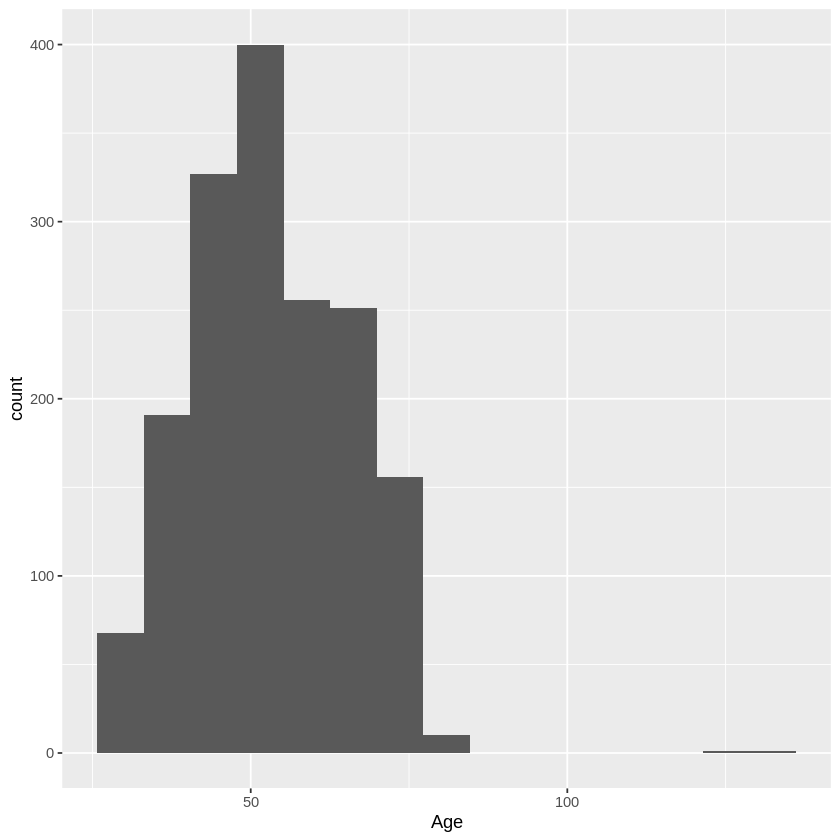

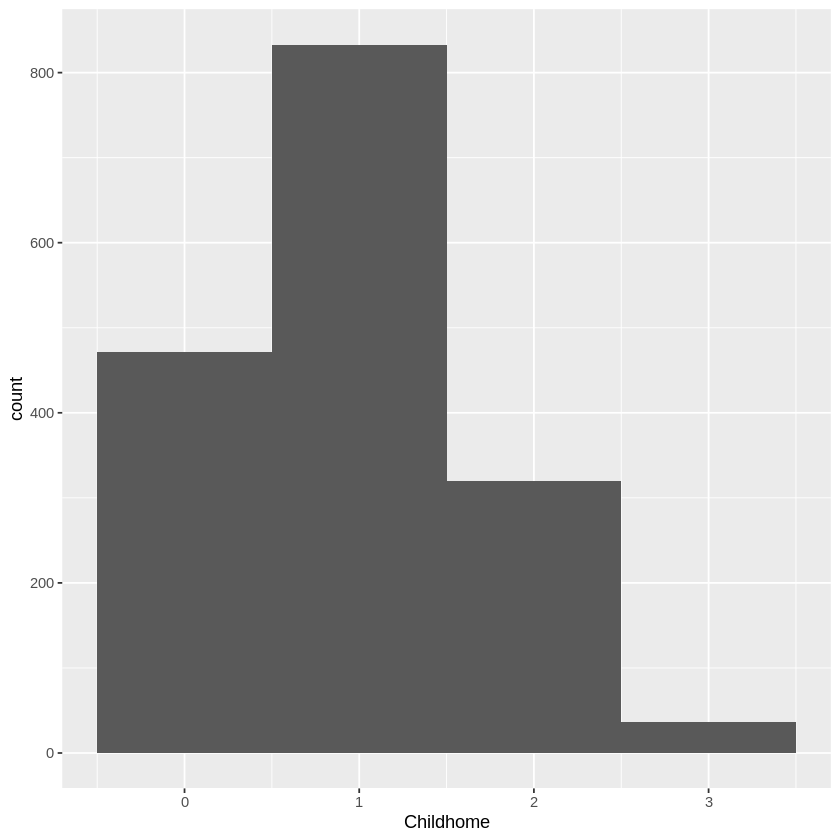

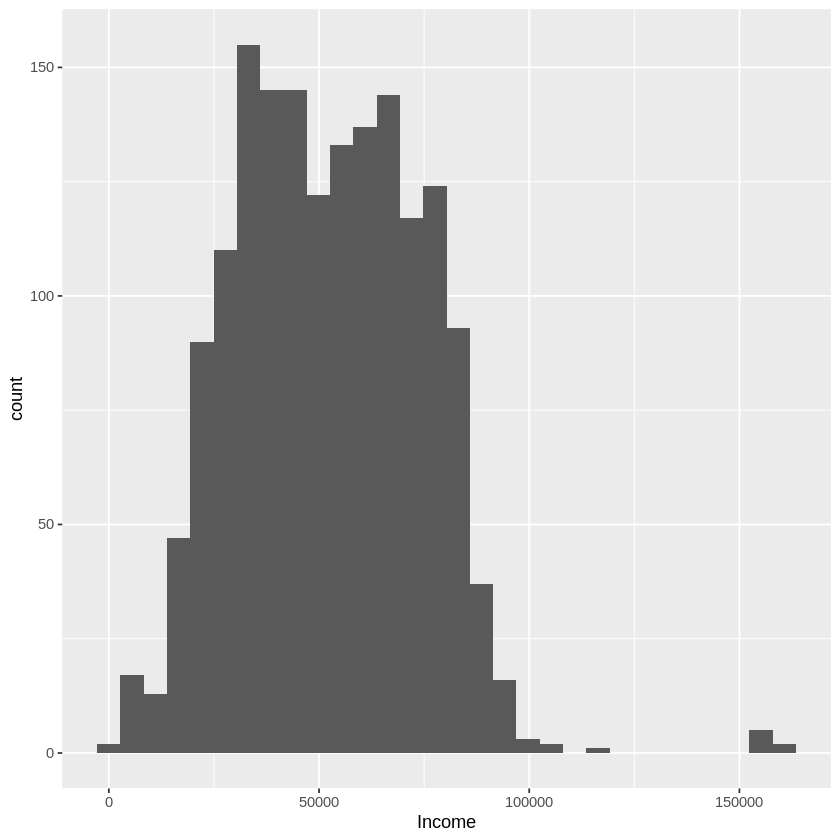

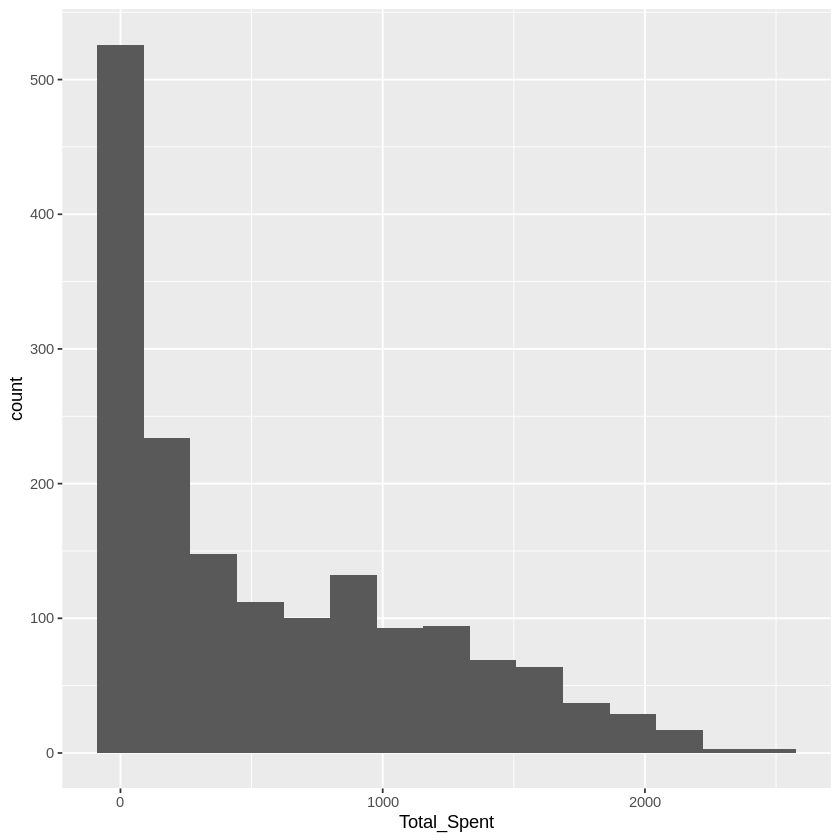

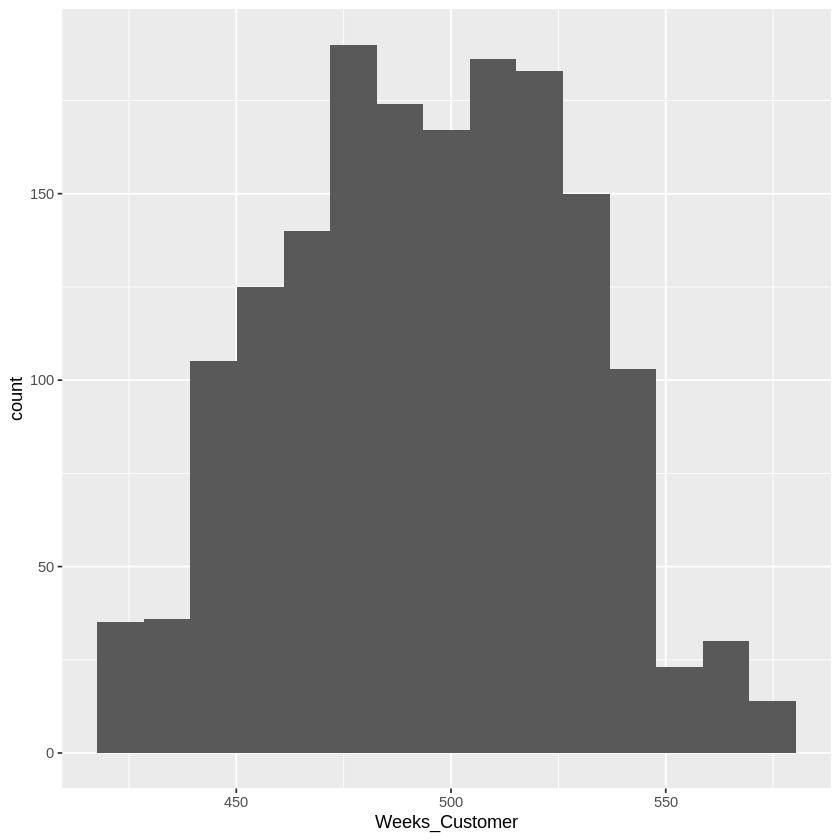

In [38]:
age_hist <- store_data_train |>
    ggplot(aes(x = Age)) +
        geom_histogram(bins = 15)
child_hist <- store_data_train |>
    ggplot(aes(x = Childhome)) +
        geom_histogram(bins = 4)
income_hist <- store_data_train |>
    filter(Income < 200000) |>
    ggplot(aes(x = Income)) +
        geom_histogram(bins = 30)
spending_hist <- store_data_train |>
    ggplot(aes(x = Total_Spent)) +
        geom_histogram(bins = 15)
weeks_hist <- store_data_train |>
    ggplot(aes(x = Weeks_Customer)) +
        geom_histogram(bins = 15)

age_hist
child_hist
income_hist
spending_hist
weeks_hist